In [8]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

## 1. CARGA Y PREPROCESAMIENTO DE DATOS 

In [9]:

base_dir = 'images'
target_size = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.6, 1.4],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train = train_datagen.flow_from_directory(os.path.join(base_dir, 'train'), target_size=target_size, batch_size=32, class_mode='binary')
val = test_datagen.flow_from_directory(os.path.join(base_dir, 'validation'), target_size=target_size, batch_size=32, class_mode='binary')
test = test_datagen.flow_from_directory(os.path.join(base_dir, 'test'), target_size=target_size, batch_size=32, class_mode='binary', shuffle=False)

Found 1492 images belonging to 2 classes.
Found 106 images belonging to 2 classes.
Found 110 images belonging to 2 classes.


## 2. MODELO CON EfficientNetB0

In [10]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True
for layer in base_model.layers[:-100]:
    layer.trainable = False

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

## 3. ENTRENAMIENTO 


In [11]:
history = model.fit(train, epochs=25, validation_data=val)

Epoch 1/25
47/47 [==============================] - 42s 826ms/step - loss: 0.7091 - accuracy: 0.5000 - val_loss: 0.7027 - val_accuracy: 0.5094
Epoch 2/25
47/47 [==============================] - 39s 829ms/step - loss: 0.7092 - accuracy: 0.4873 - val_loss: 0.6881 - val_accuracy: 0.5943
Epoch 3/25
47/47 [==============================] - 38s 812ms/step - loss: 0.6991 - accuracy: 0.5221 - val_loss: 0.6951 - val_accuracy: 0.5566
Epoch 4/25
47/47 [==============================] - 39s 818ms/step - loss: 0.7066 - accuracy: 0.5067 - val_loss: 0.7051 - val_accuracy: 0.5000
Epoch 5/25
47/47 [==============================] - 38s 805ms/step - loss: 0.6996 - accuracy: 0.5335 - val_loss: 0.7229 - val_accuracy: 0.5000
Epoch 6/25
47/47 [==============================] - 39s 825ms/step - loss: 0.6919 - accuracy: 0.5509 - val_loss: 0.6723 - val_accuracy: 0.5472
Epoch 7/25
47/47 [==============================] - 39s 815ms/step - loss: 0.7039 - accuracy: 0.5181 - val_loss: 0.6984 - val_accuracy: 0.5000

## 4. MATRIZ DE CONFUSIÓN Y REPORTE 

2/2 [==============================] - 1s 272ms/step


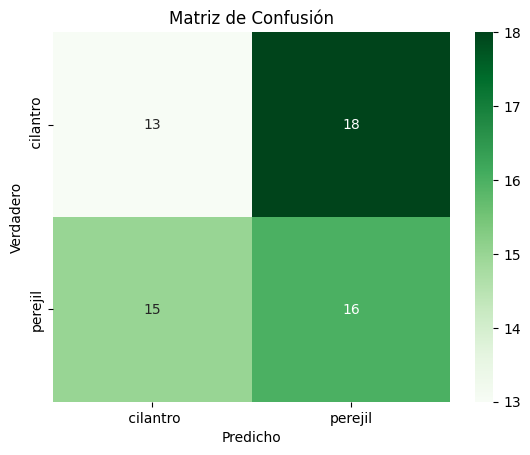

📊 Reporte de clasificación:
              precision    recall  f1-score   support

    cilantro       0.46      0.42      0.44        31
     perejil       0.47      0.52      0.49        31

    accuracy                           0.47        62
   macro avg       0.47      0.47      0.47        62
weighted avg       0.47      0.47      0.47        62



In [8]:
y_true = test.classes
y_pred_probs = model.predict(test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

labels = list(test.class_indices.keys())
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=labels, yticklabels=labels)
plt.title("Matriz de Confusión")
plt.xlabel("Predicho")
plt.ylabel("Verdadero")
plt.show()

print("📊 Reporte de clasificación:")
print(classification_report(y_true, y_pred, target_names=labels))

## 6. GRÁFICAS 

2/2 [==============================] - 1s 261ms/step - loss: 0.6969 - accuracy: 0.4516


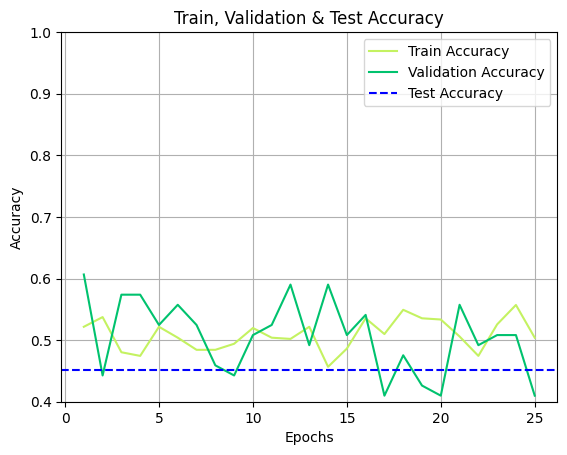

2/2 [==============================] - 1s 265ms/step - loss: 0.6964 - accuracy: 0.4839


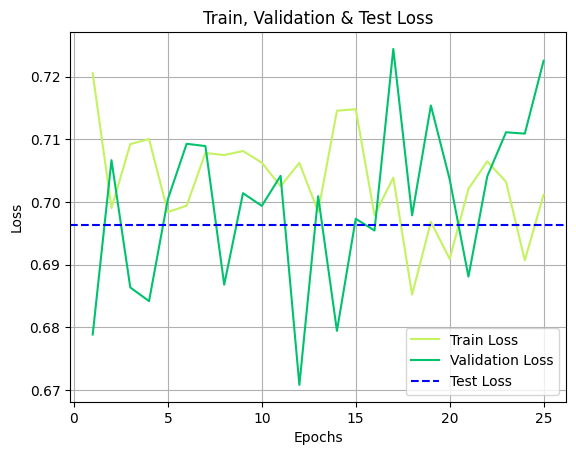

In [10]:
# === Evaluación en test ===
test_loss, test_acc = model.evaluate(test)
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

# === Accuracy Plot ===
plt.figure()
plt.plot(epochs, accuracy, color='#C4F261', label='Train Accuracy')
plt.plot(epochs, val_accuracy, color='#00C26E', label='Validation Accuracy')
plt.axhline(y=test_acc, color='blue', linestyle='--', label='Test Accuracy')
plt.title('Train, Validation & Test Accuracy')
plt.ylim(0.4, 1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# === Loss Plot ===
train_loss = history.history['loss']
val_loss = history.history['val_loss']
test_loss = model.evaluate(test)[0]

plt.figure()
plt.plot(epochs, train_loss, color='#C4F261', label='Train Loss')  
plt.plot(epochs, val_loss, color='#00C26E', label='Validation Loss')     
plt.axhline(y=test_loss, color='blue', linestyle='--', label='Test Loss')
plt.title('Train, Validation & Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## 7. GUARDAR 

In [12]:
model.save("modelo_entrenado.h5")

## 8. CARGAR MODELO

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("modelo_entrenado.h5")

In [21]:
for i, layer in enumerate(model.layers):
    print(f"{i}: {layer.name} ({type(layer)})")

0: input_2 (<class 'keras.src.engine.input_layer.InputLayer'>)
1: efficientnetb0 (<class 'keras.src.engine.functional.Functional'>)
2: global_average_pooling2d (<class 'keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D'>)
3: dropout (<class 'keras.src.layers.regularization.dropout.Dropout'>)
4: dense (<class 'keras.src.layers.core.dense.Dense'>)
